In [42]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
import torch
print("Torch: ",torch.__version__)
import torchvision
print("Torchvision: ",torchvision.__version__)
import sklearn
print("sklearn: ",sklearn.__version__)
import sys
print("Python: ",sys.version)

Torch:  1.0.0.dev20181207
Torchvision:  0.2.1
sklearn:  0.20.1
Python:  3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]


In [44]:
if torch.cuda.is_available():
    devID=torch.cuda.current_device()
    print("GPU: ",torch.cuda.get_device_name(devID))
else:
    print("Torch Cuda not avaialbe")

GPU:  GeForce GTX 1080 Ti


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [46]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *

In [47]:
PATH = '../../../../../data/DogBreeds/'

In [48]:
import os
print(os.listdir(PATH))

['train.zip', 'train', 'test.zip', 'test', 'models', 'labels.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv', 'submission.csv', 'labels.csv']


In [49]:
#print(os.listdir(PATH+'test'))

In [50]:
from zipfile import ZipFile
files = os.listdir(PATH)
if not 'train.zip' in files:
    !kaggle competitions download -c dog-breed-identification -p PATH
if not 'train' in files:    
    for file in files:
        with ZipFile(PATH+file, 'r') as zipF:
            zipF.extractall(path=PATH)
            print(file,': Done')
os.listdir(PATH)        

['train.zip',
 'train',
 'test.zip',
 'test',
 'models',
 'labels.csv.zip',
 'sample_submission.csv.zip',
 'sample_submission.csv',
 'submission.csv',
 'labels.csv']

In [51]:
tfms = get_transforms(do_flip=True)
data = ImageDataBunch.from_csv(PATH, folder='train',test='test', ds_tfms=tfms, size=224,suffix='.jpg', bs=16)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList
y: CategoryList (8178 items)
[Category boston_bull, Category dingo, Category pekinese, Category golden_retriever, Category bedlington_terrier]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (8178 items)
[Image (3, 375, 500), Image (3, 375, 500), Image (3, 375, 500), Image (3, 500, 500), Image (3, 375, 500)]...
Path: ../../../../../data/DogBreeds;

Valid: LabelList
y: CategoryList (2044 items)
[Category pomeranian, Category silky_terrier, Category redbone, Category giant_schnauzer, Category miniature_pinscher]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (2044 items)
[Image (3, 376, 500), Image (3, 375, 500), Image (3, 500, 375), Image (3, 333, 500), Image (3, 375, 500)]...
Path: ../../../../../data/DogBreeds;

Test: LabelList
y: CategoryList (10357 items)
[Category boston_bull, Category boston_bull, Category boston_bull, Category boston_bull, Category boston_bull]...
Path: ../../../../../data/DogBreeds
x: ImageItemList (10357 items)

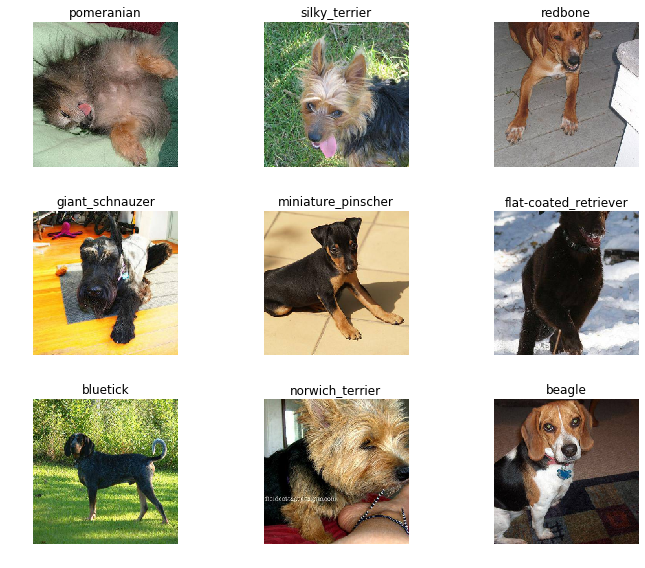

In [52]:
data.show_batch(rows=3, figsize=(10,8), ds_type=DatasetType.Valid)

In [53]:
print(data.classes)
len(data.classes),data.c

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

(120, 120)

In [54]:
learn = create_cnn(data, models.resnet152, metrics=error_rate)
#learn.interpret(tta=True)

In [55]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [56]:
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,error_rate
1,1.192889,0.632994,0.181996
2,0.996772,0.579614,0.173679
3,0.833431,0.522811,0.156067
4,0.637026,0.460215,0.133562
5,0.506362,0.403716,0.121331
6,0.420361,0.391183,0.122798


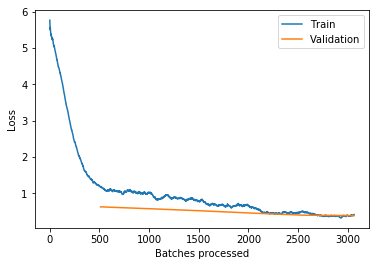

In [57]:
learn.recorder.plot_losses()

In [58]:
learn.save('stage-1')

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

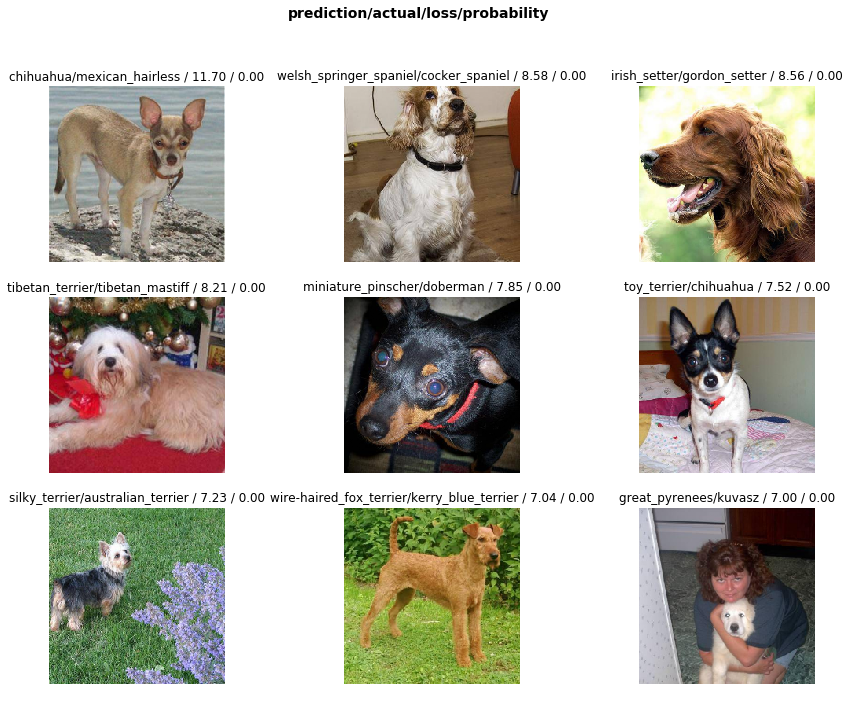

In [60]:
interp.plot_top_losses(9, figsize=(15,11))

In [61]:
doc(interp.plot_top_losses)

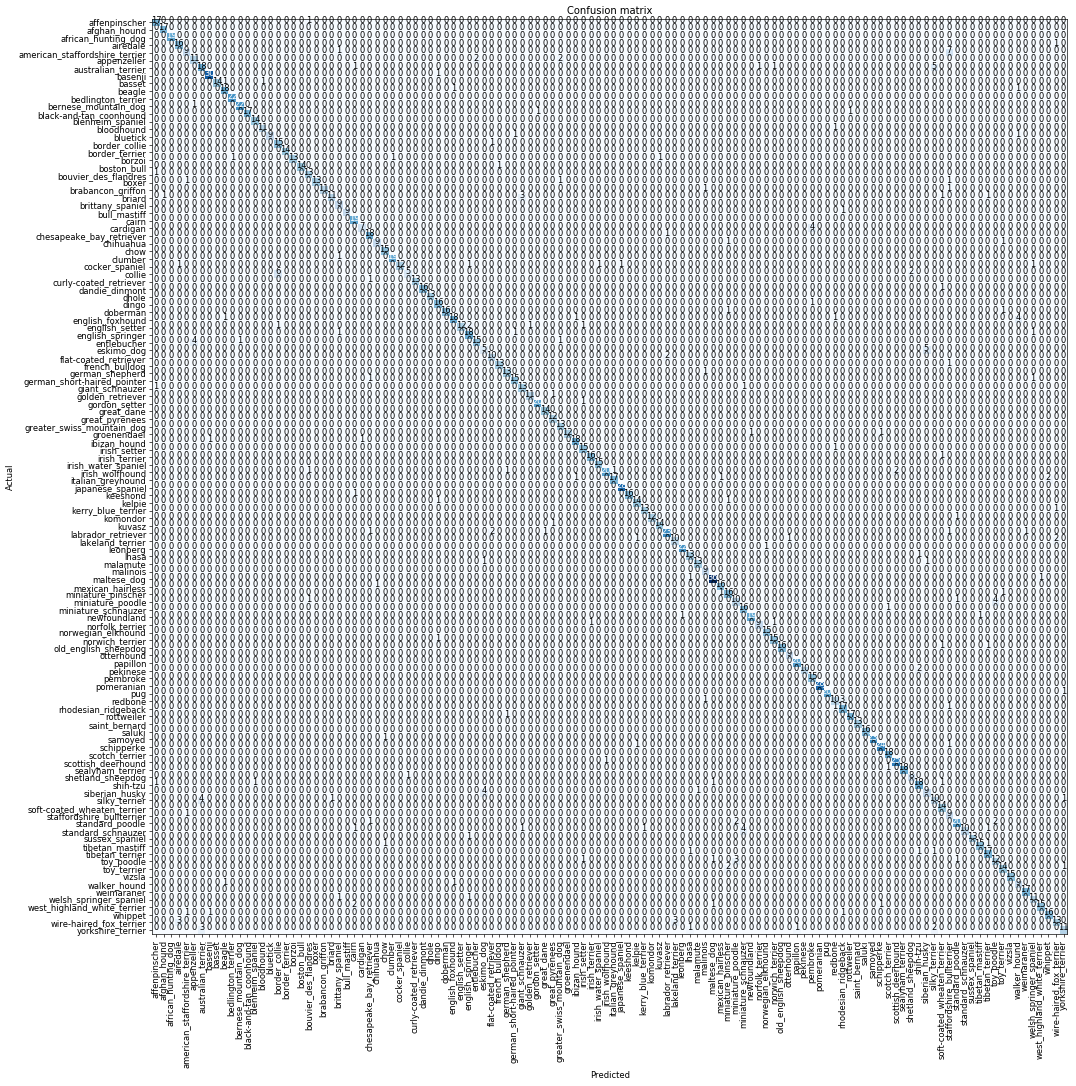

In [62]:
interp.plot_confusion_matrix(figsize=(18,18), dpi=60)

In [63]:
interp.most_confused(min_val=2)

[('american_staffordshire_terrier', 'staffordshire_bullterrier', 7),
 ('collie', 'border_collie', 6),
 ('australian_terrier', 'silky_terrier', 5),
 ('eskimo_dog', 'siberian_husky', 5),
 ('cardigan', 'pembroke', 4),
 ('english_foxhound', 'walker_hound', 4),
 ('entlebucher', 'appenzeller', 4),
 ('miniature_poodle', 'toy_poodle', 4),
 ('siberian_husky', 'eskimo_dog', 4),
 ('silky_terrier', 'australian_terrier', 4),
 ('standard_schnauzer', 'miniature_schnauzer', 4),
 ('briard', 'giant_schnauzer', 3),
 ('redbone', 'rhodesian_ridgeback', 3),
 ('toy_poodle', 'miniature_poodle', 3),
 ('wire-haired_fox_terrier', 'airedale', 3),
 ('wire-haired_fox_terrier', 'lakeland_terrier', 3),
 ('yorkshire_terrier', 'australian_terrier', 3)]

In [64]:
# Since our model is working as we expect it to, we will unfreeze our model and train some more.
learn.unfreeze()

In [65]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,1.547116,0.975730,0.289628


In [66]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


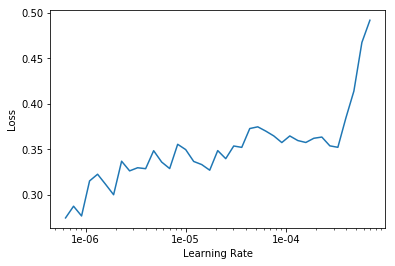

In [67]:
learn.lr_find()
learn.recorder.plot()

In [68]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,0.5e-4))

epoch,train_loss,valid_loss,error_rate
1,0.389445,0.394329,0.125734
2,0.363220,0.397367,0.121820
3,0.351051,0.391466,0.115949
4,0.293489,0.402218,0.125734
5,0.295784,0.390228,0.115949


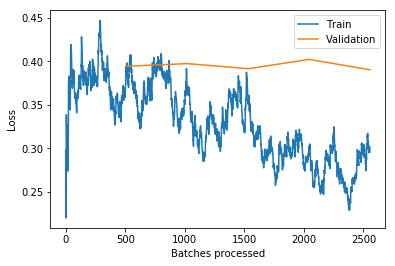

In [69]:
learn.recorder.plot_losses()

In [70]:
# from sklearn.metrics import log_loss

# log_preds, y = learn.TTA()
# probs = np.mean(np.exp(log_preds), 0)
# accuracy_np(probs, y), log_loss(y, probs)


In [71]:
# ys,y = learn.TTA()
# accuracy(ys, y)

In [72]:
# Get Predictions
predictions = learn.get_preds(ds_type=DatasetType.Test)
predictions

[tensor([[1.6565e-04, 7.7229e-05, 3.7492e-05,  ..., 1.5345e-04, 3.9175e-05,
          1.2440e-04],
         [5.5314e-04, 1.8960e-06, 1.0594e-06,  ..., 1.1996e-06, 3.4423e-05,
          9.7854e-01],
         [1.3295e-08, 4.2535e-06, 1.4167e-08,  ..., 2.2842e-10, 1.8255e-10,
          1.1856e-08],
         ...,
         [3.6197e-07, 2.4122e-08, 1.0819e-07,  ..., 1.0638e-07, 6.3624e-07,
          1.7781e-05],
         [2.9507e-08, 2.4184e-08, 8.3826e-09,  ..., 4.2207e-07, 2.8823e-09,
          3.5722e-06],
         [2.8969e-07, 4.1675e-07, 1.5900e-07,  ..., 3.1039e-06, 6.9123e-06,
          7.0752e-08]]), tensor([19, 19, 19,  ..., 19, 19, 19])]

In [73]:
sample_submission_df = pd.read_csv(PATH+'sample_submission.csv')
sample_submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [74]:
submission_df = sample_submission_df.copy()
for i in range(len(submission_df)):
    submission_df.iloc[i, 1:] = predictions[0][i].tolist()
submission_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,1.656478e-04,7.722863e-05,3.749167e-05,6.043720e-06,1.147826e-04,1.002807e-02,1.212209e-05,1.059099e-06,7.726527e-06,...,2.399651e-06,7.333868e-06,1.002186e-04,1.160239e-04,7.844098e-05,3.359610e-03,1.981150e-04,1.534531e-04,3.917476e-05,1.244042e-04
1,00102ee9d8eb90812350685311fe5890,5.531359e-04,1.895967e-06,1.059380e-06,6.938281e-06,4.922899e-07,1.029067e-05,1.290051e-03,2.537268e-06,1.324563e-07,...,3.880456e-06,7.944395e-05,6.605598e-05,1.997529e-06,2.115202e-05,3.947982e-06,4.122921e-05,1.199578e-06,3.442255e-05,9.785372e-01
2,0012a730dfa437f5f3613fb75efcd4ce,1.329522e-08,4.253525e-06,1.416724e-08,1.467015e-07,1.819034e-08,1.087889e-08,1.604389e-08,6.373157e-09,2.539041e-08,...,3.387720e-07,4.555215e-11,2.859100e-09,1.496019e-09,6.198949e-08,1.386807e-08,4.466070e-11,2.284185e-10,1.825462e-10,1.185566e-08
3,001510bc8570bbeee98c8d80c8a95ec1,3.022038e-05,5.169659e-08,1.440719e-07,9.830813e-09,2.788577e-08,3.420725e-08,2.113940e-07,1.604053e-09,6.391283e-07,...,5.887389e-10,1.382514e-08,1.701286e-07,1.620366e-07,3.733657e-08,1.103833e-08,7.519343e-08,5.549473e-08,2.700760e-07,5.883300e-07
4,001a5f3114548acdefa3d4da05474c2e,2.940238e-08,2.360471e-06,2.151459e-07,2.277081e-06,6.925002e-07,2.409773e-07,6.189487e-08,3.773614e-07,1.248661e-01,...,8.900029e-06,4.095006e-08,9.312084e-08,2.101230e-07,8.207672e-08,8.706509e-01,3.171166e-05,1.652622e-06,5.953122e-06,1.216845e-06


In [75]:
len(submission_df)

10357

In [76]:
# Submission
submission_df.to_csv(PATH+"submission.csv", index=False)